# ETL with tf & Keras

## Librairies

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.4.1'

## Paths & Config

In [2]:
DATA_DIR = "data/flower_photos"
CHECKPOINT = "models/classifier-weights.hdf5"
SAVE_MODEL_PATH = "models/classifier.h5"
TENSORBOARD = "logs"

VALIDATION_SPLIT = 0.2

WIDTH = 150
HEIGHT = 150
NUM_CHANNELS = 3
INPUT_SHAPE = (WIDTH, HEIGHT, NUM_CHANNELS)

LEARNING_RATE = 1e-4

EPOCHS = 10
BATCH_SIZE = 16

## Data

In [3]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)
train_set = generator.flow_from_directory(
    DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_set = generator.flow_from_directory(
    DATA_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
num_classes = len(train_set.class_indices)
print("Total classes:", num_classes)

Found 592 images belonging to 10 classes.
Found 144 images belonging to 10 classes.
Total classes: 10


## Model Transfer Learning

In [4]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape)

    # Freeze base model
    base_model.trainable = False

    # Build model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(name='globalaverage2d1'),
        tf.keras.layers.Dense(1024, activation='relu', name='dense1024'),
        tf.keras.layers.Dense(units=num_classes, activation='softmax', name='classifier')
    ])

    return model

model = build_model(INPUT_SHAPE, num_classes)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
globalaverage2d1 (GlobalAver (None, 2048)              0         
_________________________________________________________________
dense1024 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
classifier (Dense)           (None, 10)                10250     
Total params: 23,911,210
Trainable params: 2,108,426
Non-trainable params: 21,802,784
_________________________________________________________________
None


## Restore checkpoints

In [5]:
if os.path.exists(CHECKPOINT):
    try:
        _ = model.load_weights(CHECKPOINT, by_name=False)
    except:
        pass

## Loss & Optimizer

In [6]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE),
              metrics=["acc"])

## Callbacks

In [7]:
callback_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT,
    verbose=0,
    save_weights_only=True
)
callback_tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=TENSORBOARD,
    write_images=True
)

callbacks = [callback_checkpoint, callback_tensorboard]

## Training

In [8]:
history = model.fit(
    train_set,
    epochs=EPOCHS,
    validation_data=val_set,
    callbacks=callbacks
)

Epoch 1/10
 2/37 [>.............................] - ETA: 2:15 - loss: 0.1352 - acc: 0.9688 

/home/joseph/anaconda3/envs/tf/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


37/37 [==============================] - 206s 5s/step - loss: 0.1082 - acc: 0.9664 - val_loss: 1.8389 - val_acc: 0.5625
Epoch 2/10
37/37 [==============================] - 153s 4s/step - loss: 0.0443 - acc: 0.9887 - val_loss: 1.8090 - val_acc: 0.5764
Epoch 3/10
37/37 [==============================] - 152s 4s/step - loss: 0.0413 - acc: 0.9902 - val_loss: 1.8643 - val_acc: 0.5625
Epoch 4/10
37/37 [==============================] - 159s 4s/step - loss: 0.0289 - acc: 0.9941 - val_loss: 1.8808 - val_acc: 0.5694
Epoch 5/10
37/37 [==============================] - 152s 4s/step - loss: 0.0713 - acc: 0.9880 - val_loss: 1.8926 - val_acc: 0.5486
Epoch 6/10
37/37 [==============================] - 151s 4s/step - loss: 0.0407 - acc: 0.9855 - val_loss: 2.6645 - val_acc: 0.4792
Epoch 7/10
37/37 [==============================] - 152s 4s/step - loss: 0.0620 - acc: 0.9891 - val_loss: 2.0194 - val_acc: 0.5694
Epoch 8/10
37/37 [==============================] - 151s 4s/step - loss: 0.0218 - acc: 0.9950 

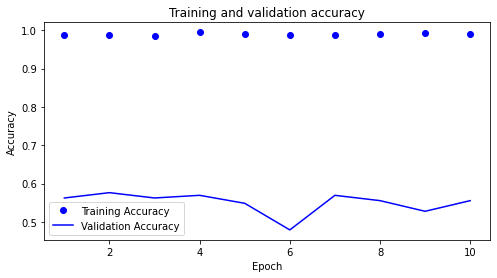

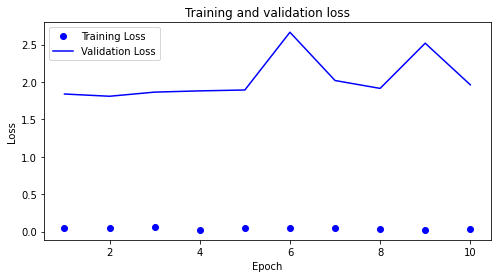

In [9]:
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.show()

## Save model

In [10]:
model.save(SAVE_MODEL_PATH)